In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("GPU device name:", torch.cuda.get_device_name(0))



CUDA available: True
GPU device name: NVIDIA A100-SXM4-40GB


In [4]:
!ls data

test_inputs.npy  train_inputs.npy  train_target_masks.npy
test_masks.npy	 train_masks.npy   train_targets.npy


In [5]:
np.load("./data/test_inputs.npy").shape

(172, 1, 134, 158)

____

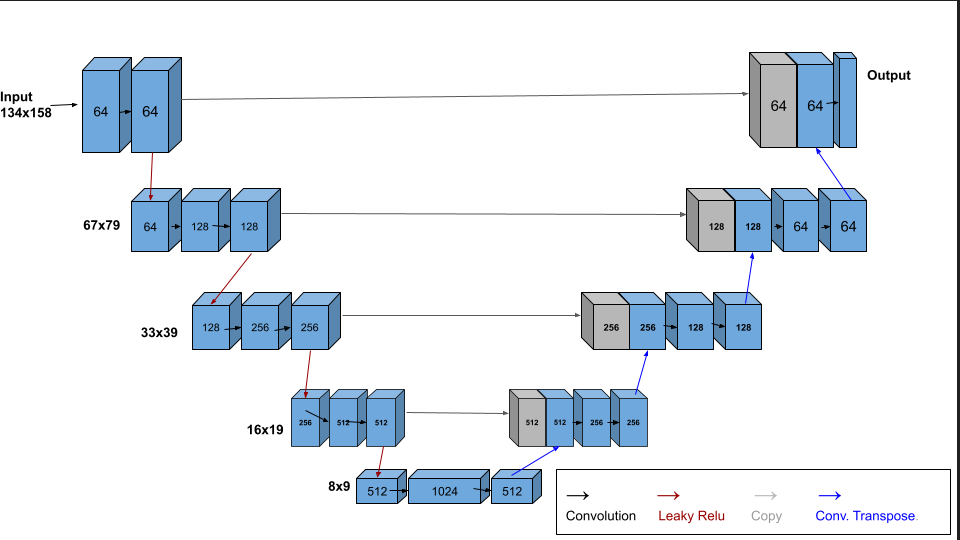

In [ ]:
class PartialConv2d(nn.Module):
    """
    Partial Convolution layer as described in the paper.
    Only considers valid (non-masked) pixels in convolution operation.
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, bias=True):
        super(PartialConv2d, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=bias)
        
        # Store kernel size for normalization
        self.kernel_size = kernel_size if isinstance(kernel_size, (tuple, list)) else (kernel_size, kernel_size)
        
        # Creating a simple averaging kernel for mask processing (no learnable parameters)
        self.register_buffer('mask_weight', torch.ones(1, 1, *self.kernel_size))
        self.stride = stride
        self.padding = padding
    
    def forward(self, x, mask):
        """
        Args:
            x: Input tensor (N, C, H, W)
            mask: Mask tensor (N, 1, H, W) where 1 = valid, 0 = invalid
        Returns:
            output: Convolved output
            new_mask: Updated mask (N, 1, H, W)
        """
        # Ensuring mask is single channel and same type as input
        if mask.shape[1] != 1:
            mask = mask[:, :1, :, :]
        mask = mask.to(x.dtype)
        
        # Checking for NaN inputs
        if torch.isnan(x).any() or torch.isnan(mask).any():
            print(f"NaN detected in PartialConv2d input!")
            return torch.zeros_like(x), mask
        
        # Ensuring mask values are valid (0 or 1)
        mask = torch.clamp(mask, 0.0, 1.0)
        
        # Broadcast mask to match input channels for masking
        mask_broadcast = mask.expand_as(x)
        
        # Applying mask to input
        masked_input = x * mask_broadcast
        
        # Performig convolution on masked input
        conv_output = self.conv(masked_input)
        
        # Count valid pixels using fixed kernel (no gradients)
        mask_sum = F.conv2d(mask, self.mask_weight, bias=None, 
                           stride=self.stride, padding=self.padding)
        
        # Calculate the maximum possible valid pixels in a convolution window
        max_valid_pixels = self.kernel_size[0] * self.kernel_size[1]
        
        # Create scaling factor: c/sum(M) from equation (1)
        # Use larger epsilon and ensure positive values
        eps = 1e-6
        mask_sum_safe = torch.clamp(mask_sum, min=eps)
        scaling_factor = max_valid_pixels / mask_sum_safe
        
        # Clamp scaling factor to prevent extreme values
        scaling_factor = torch.clamp(scaling_factor, min=0.1, max=10.0)
        
        # Broadcast scaling factor to match output channels
        scaling_factor = scaling_factor.expand_as(conv_output)
        
        # Apply scaling only where we have valid pixels
        output = conv_output * scaling_factor
        
        # Check for NaN outputs
        if torch.isnan(output).any():
            print(f"NaN detected in PartialConv2d output!")
            print(f"  conv_output range: {conv_output.min():.6f} to {conv_output.max():.6f}")
            print(f"  scaling_factor range: {scaling_factor.min():.6f} to {scaling_factor.max():.6f}")
            print(f"  mask_sum range: {mask_sum.min():.6f} to {mask_sum.max():.6f}")
            # Return zeros instead of NaN
            output = torch.zeros_like(conv_output)
            
        # Update mask: 1 where there was at least one valid input pixel, 0 otherwise
        new_mask = (mask_sum > 0).float()
        
        return output, new_mask

class DoublePartialConv(nn.Module):
    """
    Two consecutive partial convolutions as used in the UNet architecture
    """
    def __init__(self, in_channels, out_channels):
        super(DoublePartialConv, self).__init__()
        
        self.pconv1 = PartialConv2d(in_channels, out_channels, kernel_size=5, padding=2)
        self.pconv2 = PartialConv2d(out_channels, out_channels, kernel_size=5, padding=2)
        self.leaky_relu = nn.LeakyReLU(0.2, inplace=True)
    
    def forward(self, x, mask):
        # First partial convolution
        x, mask = self.pconv1(x, mask)
        x = self.leaky_relu(x)
        
        # Second partial convolution
        x, mask = self.pconv2(x, mask)
        x = self.leaky_relu(x)
        
        return x, mask

class PartialUNet(nn.Module):
    """
    UNet with Partial Convolutions for LST interpolation
    Input size: (N, 1, 134, 158) -> Output size: (N, 1, 134, 158)
    """
    def __init__(self, in_channels=1, out_channels=1):
        super(PartialUNet, self).__init__()
        
        # Encoder (Downward path)
        self.enc1 = DoublePartialConv(in_channels, 64)
        self.enc2 = DoublePartialConv(64, 128)
        self.enc3 = DoublePartialConv(128, 256)
        self.enc4 = DoublePartialConv(256, 512)
        
        # Bottleneck
        self.bottleneck = DoublePartialConv(512, 1024)
        
        # Decoder (Upward path)
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec4 = DoublePartialConv(512 + 512, 512)  # 1024 = 512 (up) + 512 (skip)
        
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec3 = DoublePartialConv(256 + 256, 256)   # 512 = 256 (up) + 256 (skip)
        
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = DoublePartialConv(128 + 128, 128)   # 256 = 128 (up) + 128 (skip)
        
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = DoublePartialConv(64 + 64, 64)    # 128 = 64 (up) + 64 (skip)
        
        # Final output layer with sigmoid to constrain to [0,1]
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()  # Constrain output to [0,1]
        
        # Max pooling for downsampling
        self.pool = nn.MaxPool2d(2, 2)
        
        # Gaussian smoothing kernel (as mentioned in paper)
        self.gaussian_kernel = self._create_gaussian_kernel()
        
        # Initialize weights for better convergence
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize network weights for stable training"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def _create_gaussian_kernel(self, kernel_size=5, sigma=0.7):
        """Create Gaussian kernel for output smoothing"""
        channels = 1
        kernel = torch.zeros(channels, channels, kernel_size, kernel_size)
        
        # Create 2D Gaussian kernel
        x_coord = torch.arange(kernel_size)
        x_grid = x_coord.repeat(kernel_size).view(kernel_size, kernel_size)
        y_grid = x_grid.t()
        xy_grid = torch.stack([x_grid, y_grid], dim=-1)
        
        mean = (kernel_size - 1) / 2.
        variance = sigma ** 2.
        
        gaussian_kernel = (1. / (2. * np.pi * variance)) * \
                         torch.exp(-torch.sum((xy_grid - mean) ** 2., dim=-1) / (2 * variance))
        
        # Normalize
        gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
        
        # Reshape for convolution
        kernel[0, 0] = gaussian_kernel
        
        return kernel
    
    def _apply_gaussian_smoothing(self, x):
        """Apply Gaussian smoothing to output"""
        if self.gaussian_kernel.device != x.device:
            self.gaussian_kernel = self.gaussian_kernel.to(x.device)
        
        # Apply smoothing with same padding to preserve size
        padding = 2  # For kernel_size=5
        smoothed = F.conv2d(x, self.gaussian_kernel, padding=padding)
        return smoothed
    
    def forward(self, x, mask):
        # Store skip connections and their masks
        skip_connections = []
        skip_masks = []
        
        # Ensure input mask is single channel
        if mask.shape[1] != 1:
            mask = mask[:, :1, :, :]
        
        # Encoder path
        x1, mask1 = self.enc1(x, mask)
        skip_connections.append(x1)
        skip_masks.append(mask1)
        x = self.pool(x1)
        mask = self.pool(mask1)
        
        x2, mask2 = self.enc2(x, mask)
        skip_connections.append(x2)
        skip_masks.append(mask2)
        x = self.pool(x2)
        mask = self.pool(mask2)
        
        x3, mask3 = self.enc3(x, mask)
        skip_connections.append(x3)
        skip_masks.append(mask3)
        x = self.pool(x3)
        mask = self.pool(mask3)
        
        x4, mask4 = self.enc4(x, mask)
        skip_connections.append(x4)
        skip_masks.append(mask4)
        x = self.pool(x4)
        mask = self.pool(mask4)
        
        # Bottleneck
        x, mask = self.bottleneck(x, mask)
        
        # Decoder path with skip connections
        x = self.up4(x)
        # Handle size mismatch for upsampling
        if x.shape[2:] != skip_connections[3].shape[2:]:
            x = F.interpolate(x, size=skip_connections[3].shape[2:], mode='bilinear', align_corners=False)
        # Create mask for upsampled features
        mask_up = F.interpolate(mask, size=skip_connections[3].shape[2:], mode='nearest')
        # Concatenate features (masks stay single channel)
        x = torch.cat([x, skip_connections[3]], dim=1)
        # For masks, we take the maximum (logical OR) to preserve valid pixels
        combined_mask = torch.max(mask_up, skip_masks[3])
        x, mask = self.dec4(x, combined_mask)
        
        x = self.up3(x)
        if x.shape[2:] != skip_connections[2].shape[2:]:
            x = F.interpolate(x, size=skip_connections[2].shape[2:], mode='bilinear', align_corners=False)
        mask_up = F.interpolate(mask, size=skip_connections[2].shape[2:], mode='nearest')
        x = torch.cat([x, skip_connections[2]], dim=1)
        combined_mask = torch.max(mask_up, skip_masks[2])
        x, mask = self.dec3(x, combined_mask)
        
        x = self.up2(x)
        if x.shape[2:] != skip_connections[1].shape[2:]:
            x = F.interpolate(x, size=skip_connections[1].shape[2:], mode='bilinear', align_corners=False)
        mask_up = F.interpolate(mask, size=skip_connections[1].shape[2:], mode='nearest')
        x = torch.cat([x, skip_connections[1]], dim=1)
        combined_mask = torch.max(mask_up, skip_masks[1])
        x, mask = self.dec2(x, combined_mask)
        
        x = self.up1(x)
        if x.shape[2:] != skip_connections[0].shape[2:]:
            x = F.interpolate(x, size=skip_connections[0].shape[2:], mode='bilinear', align_corners=False)
        mask_up = F.interpolate(mask, size=skip_connections[0].shape[2:], mode='nearest')
        x = torch.cat([x, skip_connections[0]], dim=1)
        combined_mask = torch.max(mask_up, skip_masks[0])
        x, mask = self.dec1(x, combined_mask)
        
        # Final convolution
        x = self.final_conv(x)
        
        # Apply sigmoid to constrain output to [0,1] range
        x = self.sigmoid(x)
        
        # Apply Gaussian smoothing as mentioned in the paper
        x = self._apply_gaussian_smoothing(x)
        
        return x

class LSTDataset(Dataset):
    """
    PyTorch Dataset for LST interpolation training with Min-Max normalization [0,1]
    """
    def __init__(self, inputs, masks, targets, target_masks, normalize=True):
        self.inputs = torch.FloatTensor(inputs)
        self.masks = torch.FloatTensor(masks)
        self.targets = torch.FloatTensor(targets)
        self.target_masks = torch.FloatTensor(target_masks)
        
        if normalize:
            # Calculate min/max from non-zero (valid) pixels only
            valid_pixels = (self.inputs != 0) & (self.targets != 0)
            all_valid_data = torch.cat([
                self.inputs[valid_pixels],
                self.targets[valid_pixels]
            ])
            
            self.data_min = all_valid_data.min()
            self.data_max = all_valid_data.max()
            self.data_range = self.data_max - self.data_min
            
            print(f"Data statistics - Min: {self.data_min:.2f}, Max: {self.data_max:.2f}")
            print(f"Data range: {self.data_range:.2f}")
            
            # Min-Max normalize inputs and targets to [0,1] (but keep zeros as zeros for masked pixels)
            self.inputs = self._normalize_tensor(self.inputs)
            self.targets = self._normalize_tensor(self.targets)
            
            # Verify normalization
            valid_data_norm = torch.cat([
                self.inputs[valid_pixels],
                self.targets[valid_pixels]
            ])
            print(f"Data range after norm - Min: {valid_data_norm.min():.2f}, Max: {valid_data_norm.max():.2f}")
        else:
            self.data_min = None
            self.data_max = None
            self.data_range = None
    
    def _normalize_tensor(self, tensor):
        """Min-Max normalize tensor to [0,1] while preserving zeros (masked pixels)"""
        result = tensor.clone()
        valid_mask = tensor != 0
        
        # Debug: Check what we're normalizing
        if valid_mask.sum() > 0:
            valid_data = tensor[valid_mask]
            print(f"    Normalizing {valid_mask.sum()} valid pixels:")
            print(f"    Original range: {valid_data.min():.2f} to {valid_data.max():.2f}")
            
            # Apply normalization
            result[valid_mask] = (tensor[valid_mask] - self.data_min) / self.data_range
            
            # Verify normalization worked
            normalized_data = result[valid_mask]
            print(f"    Normalized range: {normalized_data.min():.6f} to {normalized_data.max():.6f}")
            
            # Check for any issues
            if normalized_data.min() < -0.01 or normalized_data.max() > 1.01:
                print(f"    ⚠️  WARNING: Normalization failed!")
                print(f"    data_min: {self.data_min}, data_max: {self.data_max}, data_range: {self.data_range}")
        
        return result
    
    def denormalize(self, tensor):
        """Denormalize tensor back to original scale"""
        if self.data_min is None or self.data_max is None:
            return tensor
        return tensor * self.data_range + self.data_min
    
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return {
            'input': self.inputs[idx],
            'mask': self.masks[idx],
            'target': self.targets[idx],
            'target_mask': self.target_masks[idx]
        }

def partial_loss(output, target, target_mask):
    """
    Compute MSE loss only on valid pixels in target.
    Loss is computed on NORMALIZED data for stable gradients.
    """
    # Only compute loss where target_mask is 1 (valid pixels)
    valid_pixels = target_mask > 0
    if valid_pixels.sum() == 0:
        return torch.tensor(0.0, requires_grad=True)
    
    # Compute loss on normalized data (0-1 range)
    loss = F.mse_loss(output[valid_pixels], target[valid_pixels])
    return loss

def calculate_rmse(output, target, target_mask, denormalize_fn=None):
    """Calculate RMSE in original temperature units"""
    valid_pixels = target_mask > 0
    if valid_pixels.sum() == 0:
        return 0.0
    
    if denormalize_fn is not None:
        # Denormalize for RMSE calculation in real temperature units
        output_denorm = denormalize_fn(output)
        target_denorm = denormalize_fn(target)
        mse = F.mse_loss(output_denorm[valid_pixels], target_denorm[valid_pixels])
    else:
        # If no denormalization function, compute RMSE on normalized data
        mse = F.mse_loss(output[valid_pixels], target[valid_pixels])
    
    return torch.sqrt(mse).item()

def train_model(model, train_loader, val_loader, num_epochs=100, device='cuda'):
    """
    Training function for the Partial UNet model with proper loss scaling
    """
    model.to(device)
    # Even more conservative settings
    optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-6)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 60], gamma=0.5)
    
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    train_rmse_history = []
    val_rmse_history = []
    
    # Get denormalization function from dataset
    denormalize_fn = None
    if hasattr(train_loader.dataset, 'denormalize'):
        denormalize_fn = train_loader.dataset.denormalize
    
    # Debug: Check first batch to ensure data is normalized
    debug_batch = next(iter(train_loader))
    debug_inputs = debug_batch['input']
    debug_targets = debug_batch['target']
    debug_masks = debug_batch['target_mask']
    
    # Check only valid (non-masked) pixels
    valid_pixels = debug_masks > 0
    valid_inputs = debug_inputs[valid_pixels]
    valid_targets = debug_targets[valid_pixels]
    
    print(f"DEBUG - First batch data ranges:")
    print(f"  Input range: {valid_inputs.min().item():.6f} to {valid_inputs.max().item():.6f}")
    print(f"  Target range: {valid_targets.min().item():.6f} to {valid_targets.max().item():.6f}")
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_rmse = 0.0
        num_batches = 0
        nan_batches = 0
        
        for batch_idx, batch in enumerate(train_loader):
            inputs = batch['input'].to(device)
            masks = batch['mask'].to(device)
            targets = batch['target'].to(device)
            target_masks = batch['target_mask'].to(device)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs, masks)
            
            # Check for NaN in outputs
            if torch.isnan(outputs).any():
                print(f"Skipping batch {batch_idx} due to NaN outputs")
                nan_batches += 1
                continue
            
            # DEBUG: Check data ranges in first epoch
            if epoch == 0 and batch_idx == 0:
                valid_pixels = target_masks > 0
                print(f"  Batch inputs range: {inputs[valid_pixels].min().item():.6f} to {inputs[valid_pixels].max().item():.6f}")
                print(f"  Batch targets range: {targets[valid_pixels].min().item():.6f} to {targets[valid_pixels].max().item():.6f}")
                print(f"  Batch outputs range: {outputs[valid_pixels].min().item():.6f} to {outputs[valid_pixels].max().item():.6f}")
            
            # Compute loss on NORMALIZED data (for stable gradients)
            loss = partial_loss(outputs, targets, target_masks)
            
            # Check for NaN loss
            if torch.isnan(loss):
                print(f"Skipping batch {batch_idx} due to NaN loss")
                nan_batches += 1
                continue
            
            # Compute RMSE in original temperature units (for monitoring)
            rmse = calculate_rmse(outputs, targets, target_masks, denormalize_fn)
            
            # DEBUG: Check loss scale in first epoch
            if epoch == 0 and batch_idx == 0:
                print(f"  First batch loss: {loss.item():.6f}")
            
            # Backward pass
            loss.backward()
            
            # Check for NaN gradients
            has_nan_grad = False
            for param in model.parameters():
                if param.grad is not None and torch.isnan(param.grad).any():
                    has_nan_grad = True
                    break
            
            if has_nan_grad:
                print(f"Skipping batch {batch_idx} due to NaN gradients")
                nan_batches += 1
                optimizer.zero_grad()
                continue
            
            # Gradient clipping to prevent instability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            
            optimizer.step()
            
            train_loss += loss.item()
            train_rmse += rmse
            num_batches += 1
        
        # Check if we lost too many batches to NaN
        if nan_batches > len(train_loader) * 0.5:  # More than 50% NaN batches
            print(f"Too many NaN batches ({nan_batches}/{len(train_loader)}) in epoch {epoch}")
            print("Training unstable - consider reducing learning rate or checking data")
        
        # Prevent division by zero
        if num_batches == 0:
            print(f"No valid batches in epoch {epoch}, breaking training")
            break
            
        avg_train_loss = train_loss / num_batches
        avg_train_rmse = train_rmse / num_batches
        train_losses.append(avg_train_loss)
        train_rmse_history.append(avg_train_rmse)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_rmse = 0.0
        num_val_batches = 0
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['input'].to(device)
                masks = batch['mask'].to(device)
                targets = batch['target'].to(device)
                target_masks = batch['target_mask'].to(device)
                
                outputs = model(inputs, masks)
                
                # Skip batch if NaN detected
                if torch.isnan(outputs).any():
                    continue
                
                # Loss on normalized data
                loss = partial_loss(outputs, targets, target_masks)
                
                # Skip if loss is NaN
                if torch.isnan(loss):
                    continue
                
                # RMSE in original temperature units
                rmse = calculate_rmse(outputs, targets, target_masks, denormalize_fn)
                
                val_loss += loss.item()
                val_rmse += rmse
                num_val_batches += 1
        
        if num_val_batches > 0:
            avg_val_loss = val_loss / num_val_batches
            avg_val_rmse = val_rmse / num_val_batches
        else:
            avg_val_loss = float('inf')
            avg_val_rmse = float('inf')
            
        val_losses.append(avg_val_loss)
        val_rmse_history.append(avg_val_rmse)
        
        # Update learning rate
        scheduler.step()
        
        # Save best model
        if avg_val_loss < best_val_loss and not torch.isnan(torch.tensor(avg_val_loss)):
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_partial_unet.pth')
        
        # Print progress with both loss and RMSE
        if epoch % 5 == 0 or epoch == num_epochs - 1:
            print(f'Epoch [{epoch+1:3d}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.6f}, Train RMSE: {avg_train_rmse:.2f}, '
                  f'Val Loss: {avg_val_loss:.6f}, Val RMSE: {avg_val_rmse:.2f} '
                  f'(NaN batches: {nan_batches})')
                  
        # Early stopping if loss is increasing consistently
        if len(train_losses) > 10:
            recent_losses = train_losses[-10:]
            if all(recent_losses[i] >= recent_losses[i-1] for i in range(1, len(recent_losses))):
                print("Loss consistently increasing - stopping training")
                break
    
    return train_losses, val_losses, train_rmse_history , val_rmse_history

def test_model_dimensions():
    """Test the model with your data dimensions to ensure compatibility"""
    # Create dummy data with your exact dimensions
    batch_size = 2
    channels = 1
    height, width = 134, 158
    
    dummy_input = torch.randn(batch_size, channels, height, width)
    dummy_mask = torch.ones(batch_size, channels, height, width)
    
    # Create model and test forward pass
    model = PartialUNet(in_channels=1, out_channels=1)
    model.eval()
    
    print(f"Testing model with input shape: {dummy_input.shape}")
    print(f"Testing model with mask shape: {dummy_mask.shape}")
    
    try:
        with torch.no_grad():
            output = model(dummy_input, dummy_mask)
        print(f"✓ Model test successful! Output shape: {output.shape}")
        return True
    except Exception as e:
        print(f"✗ Model test failed: {e}")
        import traceback
        traceback.print_exc()
        return False
        

In [7]:
print("Testing model architecture...")
if not test_model_dimensions():
    raise("Model test failed. Please check the architecture.")

# Load your data (assuming you've saved it as shown in your code)
inputs = np.load('./data/train_inputs.npy')
masks = np.load('./data/train_masks.npy')
targets = np.load('./data/train_targets.npy')
target_masks = np.load('./data/train_target_masks.npy')

print(f"Loaded data shapes:")
print(f"Inputs: {inputs.shape}")
print(f"Masks: {masks.shape}")
print(f"Targets: {targets.shape}")
print(f"Target masks: {target_masks.shape}")


Testing model architecture...


Testing model with input shape: torch.Size([2, 1, 134, 158])
Testing model with mask shape: torch.Size([2, 1, 134, 158])
✓ Model test successful! Output shape: torch.Size([2, 1, 134, 158])
Loaded data shapes:
Inputs: (351, 1, 134, 158)
Masks: (351, 1, 134, 158)
Targets: (351, 1, 134, 158)
Target masks: (351, 1, 134, 158)


In [8]:
# Split data into train and validation
train_size = int(0.8 * len(inputs))

train_inputs = inputs[:train_size]
train_masks = masks[:train_size]
train_targets = targets[:train_size]
train_target_masks = target_masks[:train_size]

val_inputs = inputs[train_size:]
val_masks = masks[train_size:]
val_targets = targets[train_size:]
val_target_masks = target_masks[train_size:]


In [ ]:
train_dataset = LSTDataset(train_inputs, train_masks, train_targets, train_target_masks, normalize=True)
val_dataset = LSTDataset(val_inputs, val_masks, val_targets, val_target_masks, normalize=False)

Data statistics - Min: 271.90, Max: 339.60
Data range: 67.70
    Normalizing 3063768 valid pixels:
    Original range: 271.90 to 339.60
    Normalized range: 0.000000 to 1.000000
    Normalizing 4055332 valid pixels:
    Original range: 271.90 to 339.60
    Normalized range: 0.000000 to 1.000000
Data range after norm - Min: 0.00, Max: 1.00


### training the Model

In [ ]:
# Create datasets and dataloaders with normalization
print("\nCreating normalized datasets...")
train_dataset = LSTDataset(train_inputs, train_masks, train_targets, train_target_masks, normalize=True)
val_dataset = LSTDataset(val_inputs, val_masks, val_targets, val_target_masks, normalize=False)

# Use training dataset's normalization parameters for validation
if train_dataset.data_min is not None:
    val_dataset.data_min = train_dataset.data_min
    val_dataset.data_max = train_dataset.data_max
    val_dataset.data_range = train_dataset.data_range
    val_dataset.inputs = val_dataset._normalize_tensor(val_dataset.inputs)
    val_dataset.targets = val_dataset._normalize_tensor(val_dataset.targets)

train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=6, shuffle=False)

# Create model
model = PartialUNet(in_channels=1, out_channels=1)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Train model
print("\nStarting training...")
train_losses, val_losses, train_rmse_history , val_rmse_history = train_model(model, train_loader, val_loader, num_epochs=100, device=device)

print("Training completed!")
print(f"Final validation loss: {val_losses[-1]:.4f}")


Creating normalized datasets...
Data statistics - Min: 271.90, Max: 339.60
Data range: 67.70
    Normalizing 3063768 valid pixels:
    Original range: 271.90 to 339.60
    Normalized range: 0.000000 to 1.000000
    Normalizing 4055332 valid pixels:
    Original range: 271.90 to 339.60


    Normalized range: 0.000000 to 1.000000
Data range after norm - Min: 0.00, Max: 1.00
    Normalizing 757563 valid pixels:
    Original range: 275.62 to 328.00
    Normalized range: 0.054948 to 0.828656
    Normalizing 1038267 valid pixels:
    Original range: 275.20 to 328.00
    Normalized range: 0.048745 to 0.828656
Using device: cuda

Starting training...
DEBUG - First batch data ranges:
  Input range: 0.000000 to 0.842245
  Target range: 0.090399 to 0.842245
  Batch inputs range: 0.000000 to 0.708419
  Batch targets range: 0.085968 to 0.708419
  Batch outputs range: 0.164287 to 1.000000
  First batch loss: 0.170953
Epoch [  1/100], Train Loss: 0.027051, Train RMSE: 10.70, Val Loss: 0.018587, Val RMSE: 9.15 (NaN batches: 0)
Epoch [  6/100], Train Loss: 0.002031, Train RMSE: 3.03, Val Loss: 0.002031, Val RMSE: 2.99 (NaN batches: 0)
Epoch [ 11/100], Train Loss: 0.000936, Train RMSE: 2.06, Val Loss: 0.001119, Val RMSE: 2.22 (NaN batches: 0)
Epoch [ 16/100], Train Loss: 0.000716, Tra

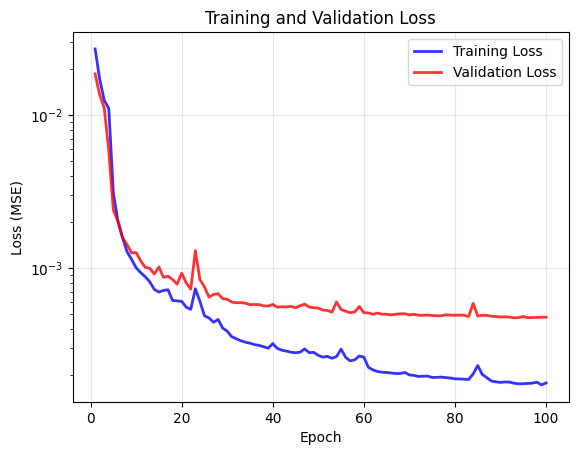

In [ ]:
plt.style.use('default')

epochs = range(1, len(train_losses) + 1)

plt.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2, alpha=0.8)
plt.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2, alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
# plt.savefig('./plots/model_loss.png') 

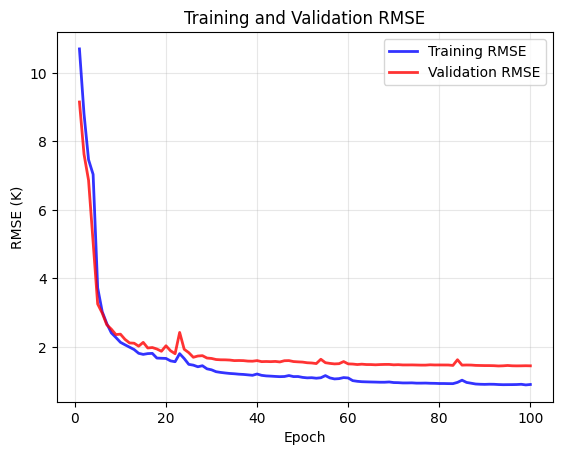

In [ ]:
plt.plot(epochs, train_rmse_history, 'b-', label='Training RMSE', linewidth=2, alpha=0.8)
plt.plot(epochs, val_rmse_history, 'r-', label='Validation RMSE', linewidth=2, alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('RMSE (K)')
plt.title('Training and Validation RMSE')
plt.legend()
plt.grid(True, alpha=0.3)
# plt.savefig('./plots/model_rmse.png') 

### Performing Test Set Evaluation:

In [12]:
# Load test data
test_inputs = np.load('./data/test_inputs.npy')
test_masks = np.load('./data/test_masks.npy')

In [ ]:
print("\nCreating normalized datasets...")
train_dataset = LSTDataset(train_inputs, train_masks, train_targets, train_target_masks, normalize=True)
val_dataset = LSTDataset(val_inputs, val_masks, val_targets, val_target_masks, normalize=False)

# Using training dataset's normalization parameters for validation
if train_dataset.data_min is not None:
    val_dataset.data_min = train_dataset.data_min
    val_dataset.data_max = train_dataset.data_max
    val_dataset.data_range = train_dataset.data_range
    val_dataset.inputs = val_dataset._normalize_tensor(val_dataset.inputs)
    val_dataset.targets = val_dataset._normalize_tensor(val_dataset.targets)

# CREATING TEST DATASET WITH SAME NORMALIZATION PARAMETERS

print("Creating test dataset with same normalization parameters...")

# For test data, we don't have targets, so create dummy targets (zeros)
dummy_test_targets = np.zeros_like(test_inputs)
dummy_test_target_masks = np.zeros_like(test_masks)

# Create test dataset (without normalization yet)
test_dataset = LSTDataset(test_inputs, test_masks, dummy_test_targets, dummy_test_target_masks, normalize=False)

# Applying the SAME normalization parameters from training
if train_dataset.data_min is not None:
    test_dataset.data_min = train_dataset.data_min
    test_dataset.data_max = train_dataset.data_max
    test_dataset.data_range = train_dataset.data_range
    
    # Normalize test inputs using training parameters
    test_dataset.inputs = test_dataset._normalize_tensor(test_dataset.inputs)
    
    print(f"Test dataset normalized with training parameters:")
    print(f"  Min: {train_dataset.data_min:.2f}, Max: {train_dataset.data_max:.2f}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=6, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=6, shuffle=False)

print(f"Created data loaders:")
print(f"  Train: {len(train_loader)} batches")
print(f"  Validation: {len(val_loader)} batches") 
print(f"  Test: {len(test_loader)} batches")


Creating normalized datasets...
Data statistics - Min: 271.90, Max: 339.60
Data range: 67.70
    Normalizing 3063768 valid pixels:
    Original range: 271.90 to 339.60
    Normalized range: 0.000000 to 1.000000
    Normalizing 4055332 valid pixels:
    Original range: 271.90 to 339.60
    Normalized range: 0.000000 to 1.000000
Data range after norm - Min: 0.00, Max: 1.00
    Normalizing 757563 valid pixels:
    Original range: 275.62 to 328.00
    Normalized range: 0.054948 to 0.828656
    Normalizing 1038267 valid pixels:
    Original range: 275.20 to 328.00
    Normalized range: 0.048745 to 0.828656
Creating test dataset with same normalization parameters...
    Normalizing 1914534 valid pixels:
    Original range: 273.10 to 326.52
    Normalized range: 0.017725 to 0.806794
Test dataset normalized with training parameters:
  Min: 271.90, Max: 339.60
Created data loaders:
  Train: 47 batches
  Validation: 12 batches
  Test: 29 batches


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


### Creating Masks for Visualization:

In [20]:
df = pd.read_parquet("matched_lst_station_temp.parquet")

In [21]:
d_array = df.to_xarray()
x_array = d_array.modis_LST
x_array = x_array.astype(np.float32)
mask_array = ~np.isnan(x_array)
mask_array = mask_array.astype(np.float32)

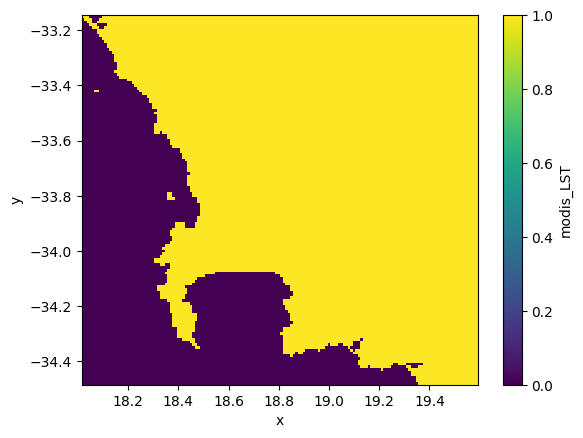

In [22]:
lst_mask = mask_array.sum('time') > 0
lst_mask.plot()

In [23]:
lst_mask

<xarray.DataArray 'modis_LST' (y: 134, x: 158)> Size: 21kB
array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], shape=(134, 158))
Coordinates:
  * y        (y) float64 1kB -34.48 -34.47 -34.46 ... -33.17 -33.16 -33.15
  * x        (x) float64 1kB 18.02 18.03 18.04 18.05 ... 19.56 19.57 19.58 19.59

In [24]:
ground_msk = lst_mask.to_numpy()

In [25]:
ground_msk

array([[False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       ...,
       [False, False,  True, ...,  True,  True,  True],
       [False,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]], shape=(134, 158))

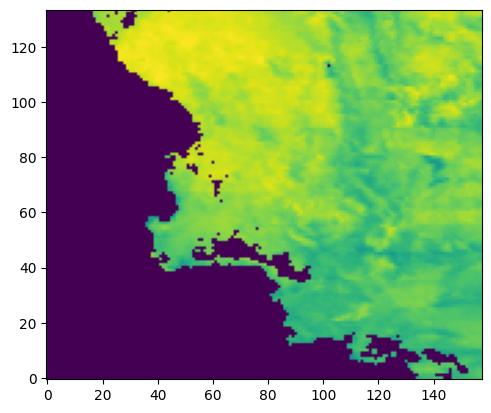

In [30]:
plt.imshow(train_dataset[0]['input'].squeeze().numpy(), origin='lower')

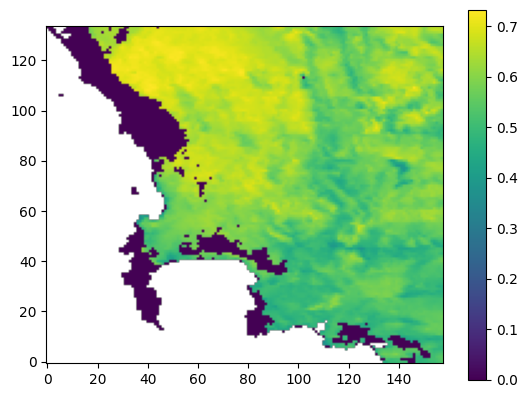

In [ ]:
input_img = train_dataset[0]['input'].squeeze().numpy()
masked_input = np.ma.masked_where(~ground_msk, input_img)

plt.imshow(masked_input, origin='lower', cmap='viridis')
plt.colorbar()


In [ ]:
def visualize_sample_prediction(model, train_dataset, device='cuda', sample_idx=0):
    """
    Visualize a single sample: original -> masked input -> prediction
    """
    model.eval()
    
    # Get a sample from the dataset
    sample = train_dataset[sample_idx]
    
    # Prepare tensors
    input_img = sample['input'].unsqueeze(0).to(device)  # Add batch dimension
    input_mask = sample['mask'].unsqueeze(0).to(device)
    target = sample['target'].unsqueeze(0).to(device)
    target_mask = sample['target_mask'].unsqueeze(0).to(device)
    
    # Get model prediction
    with torch.no_grad():
        prediction = model(input_img, input_mask)
    
    # Convert to numpy and denormalize back to Kelvin
    target_np = train_dataset.denormalize(target).cpu().numpy()[0, 0]  # Original full image
    input_np = train_dataset.denormalize(input_img).cpu().numpy()[0, 0]  # Masked input
    pred_np = train_dataset.denormalize(prediction).cpu().numpy()[0, 0]  # Prediction
    mask_np = input_mask.cpu().numpy()[0, 0]  # Mask (1=valid, 0=missing)
    
    # Create masked version for visualization (NaN where masked)
    input_masked = input_np.copy()
    input_masked[mask_np == 0] = np.nan
    
    # Calculate error :
    # Get data masks
    input_mask_np = input_mask.cpu().numpy()[0, 0].astype(bool)  # Data availability mask
    target_mask_np = target_mask.cpu().numpy()[0, 0].astype(bool)  # Target validity mask

    # For error calculation, only compute where we have valid target data AND within study area
    input_combined_mask = input_mask_np & ground_msk
    valid_comparison_mask = target_mask_np & ground_msk

    error = (pred_np - target_np)

    valid_pixels = valid_comparison_mask
    if valid_pixels.sum() > 0:
        valid_error = error[valid_pixels]
        rmse = np.sqrt(np.mean(valid_error**2))
        mae = np.mean(np.abs(valid_error))
        bias = np.mean(valid_error)
    else:
        rmse = mae = bias = 0
        valid_error = np.array([])
        
    # Create the plot
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Temperature range for consistent coloring
    vmin, vmax = 270, 340
    
    # 1. Original complete image (target/ground truth)
    
    target_masked = np.ma.masked_where(~target_mask_np, target_np)
    im1 = axes[0, 0].imshow(target_masked, origin='lower')
    axes[0, 0].set_title(f'Original Complete Image (Sample {sample_idx})')
    axes[0, 0].axis('off')
    plt.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
    
    # 2. Masked input (with gaps)
    input_coverage = input_combined_mask.sum() / ground_msk.sum() * 100
    im2 = axes[0, 1].imshow(input_masked, origin='lower')
    axes[0, 1].set_title(f'Input with Gaps\nCoverage: {input_coverage:.1f}% of study area')
    axes[0, 1].axis('off')
    plt.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)
    
    # 3. Model prediction
    pred_masked = np.ma.masked_where(~ground_msk, pred_np)
    im3 = axes[1, 0].imshow(pred_masked, origin='lower')
    im3.set_clim(im1.get_clim())
    axes[1, 0].set_title('Model Prediction')
    axes[1, 0].axis('off')
    plt.colorbar(im3, ax=axes[1, 0], fraction=0.046, pad=0.04)
    
    # 4. Absolute error
    error_masked = np.ma.masked_where(~valid_comparison_mask, error)
    im4 = axes[1, 1].imshow(error_masked, origin='lower', cmap='RdBu_r')
    axes[1, 1].set_title(f'Prediction Error\n(Pred - Target, RMSE: {rmse:.2f} deg. C)')
    axes[1, 1].axis('off')
    plt.colorbar(im4, ax=axes[1, 1], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.suptitle('Partial Convolution UNet: LST Gap Filling', fontsize=14, y=1.02)
    plt.show()
    
    # Print some statistics
    print(f"Sample {sample_idx} Statistics:")
    print(f"  Original temp range: {target_np.min():.1f}K to {target_np.max():.1f}K")
    print(f"  Input coverage: {mask_np.mean()*100:.1f}%")
    print(f"  Prediction RMSE: {rmse:.2f}K")
    print(f"  Max error: {error.max():.2f}K")


In [ ]:
# model = PartialUNet(in_channels=1, out_channels=1)

In [ ]:
# Load trained model
# model.load_state_dict(torch.load('best_partial_unet_main.pth'))

<All keys matched successfully>

In [ ]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [65]:
model = model.to(device)


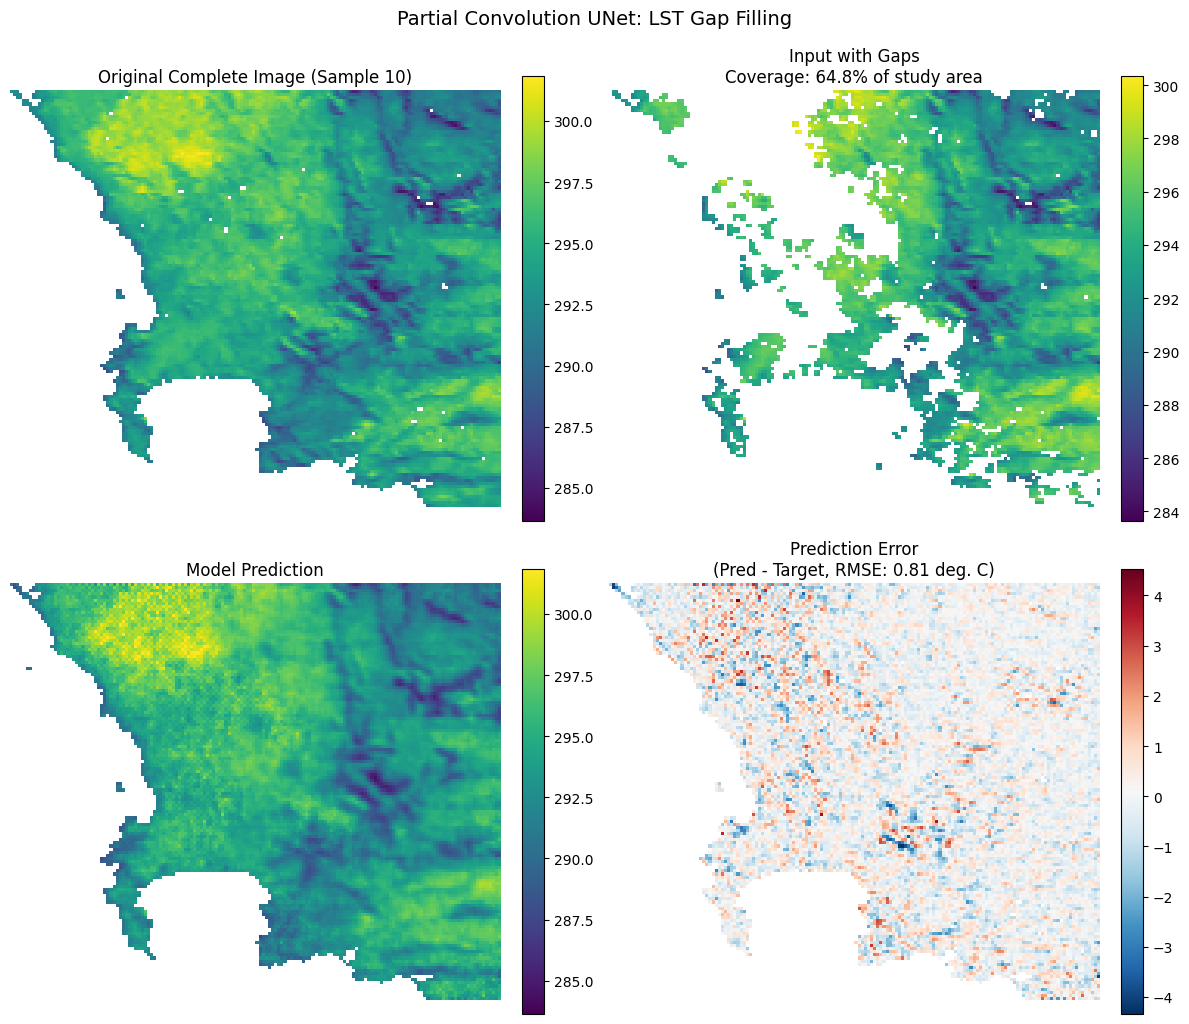

Sample 10 Statistics:
  Original temp range: 271.9K to 301.8K
  Input coverage: 45.5%
  Prediction RMSE: 0.81K
  Max error: 60.63K


In [ ]:
visualize_sample_prediction(model, train_dataset, device=device, sample_idx=10)

In [ ]:
def visualize_sample_prediction_with_ground_mask(model, train_dataset, ground_msk, device='cuda', sample_idx=0):
    """
    Visualize a single sample with external ground mask applied to define visualization bounds
    
    Args:
        model: Trained model
        train_dataset: Training dataset
        ground_msk: External boolean mask defining the study area/bounds (True=show, False=hide)
        device: Device to run inference on
        sample_idx: Sample index to visualize
    """
    # Ensure model is on correct device
    device = torch.device(device if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    # Get a sample from the dataset
    sample = train_dataset[sample_idx]
    
    # Prepare tensors
    input_img = sample['input'].unsqueeze(0).to(device)  # Add batch dimension
    input_mask = sample['mask'].unsqueeze(0).to(device)
    target = sample['target'].unsqueeze(0).to(device)
    target_mask = sample['target_mask'].unsqueeze(0).to(device)
    
    # Get model prediction
    with torch.no_grad():
        prediction = model(input_img, input_mask)
    
    # Convert to numpy and denormalize back to Kelvin
    target_np = train_dataset.denormalize(target).cpu().numpy()[0, 0]  # Original full image
    input_np = train_dataset.denormalize(input_img).cpu().numpy()[0, 0]  # Masked input
    pred_np = train_dataset.denormalize(prediction).cpu().numpy()[0, 0]  # Prediction
    
    # Get data masks
    input_mask_np = input_mask.cpu().numpy()[0, 0].astype(bool)  # Data availability mask
    target_mask_np = target_mask.cpu().numpy()[0, 0].astype(bool)  # Target validity mask
    
    # Apply ground mask to define visualization bounds
    # Areas outside study region will be masked (transparent)
    target_masked = np.ma.masked_where(~ground_msk, target_np)
    pred_masked = np.ma.masked_where(~ground_msk, pred_np)
    
    # For input, apply both data mask AND ground mask
    # Hide pixels that are either: (1) missing data, OR (2) outside study area
    input_combined_mask = input_mask_np & ground_msk
    input_masked = np.ma.masked_where(~input_combined_mask, input_np)
    
    # For error calculation, only compute where we have valid target data AND within study area
    valid_comparison_mask = target_mask_np & ground_msk
    error = (pred_np - target_np)
    error_masked = np.ma.masked_where(~valid_comparison_mask, error)
    
    # Calculate statistics only within the study area
    valid_pixels = valid_comparison_mask
    if valid_pixels.sum() > 0:
        valid_error = error[valid_pixels]
        rmse = np.sqrt(np.mean(valid_error**2))
        mae = np.mean(np.abs(valid_error))
        bias = np.mean(valid_error)
    else:
        rmse = mae = bias = 0
        valid_error = np.array([])
    
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Temperature range for consistent coloring
    vmin, vmax = 270, 340
    
    # 1. Original complete image (target/ground truth) - with ground mask
    im1 = axes[0, 0].imshow(target_masked, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
    axes[0, 0].set_title(f'Ground Truth (Sample {sample_idx})\nStudy area: {ground_msk.sum():,} pixels')
    axes[0, 0].axis('off')
    plt.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
    
    # 2. Masked input (with data gaps AND ground mask)
    im2 = axes[0, 1].imshow(input_masked, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
    input_coverage = input_combined_mask.sum() / ground_msk.sum() * 100
    axes[0, 1].set_title(f'Input with Gaps\nCoverage: {input_coverage:.1f}% of study area')
    axes[0, 1].axis('off')
    plt.colorbar(im2, ax=axes[0, 1], fraction=0.046, pad=0.04)
    
    # 3. Ground mask visualization
    im3 = axes[0, 2].imshow(ground_msk, origin='lower', cmap='RdYlGn', vmin=0, vmax=1)
    axes[0, 2].set_title('Study Area Mask\n(Green=Study area, Red=Outside)')
    axes[0, 2].axis('off')
    plt.colorbar(im3, ax=axes[0, 2], fraction=0.046, pad=0.04)
    
    # 4. Model prediction - with ground mask
    im4 = axes[1, 0].imshow(pred_masked, origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
    axes[1, 0].set_title(f'Model Prediction\nRange: {pred_np[ground_msk].min():.1f}-{pred_np[ground_msk].max():.1f}K')
    axes[1, 0].axis('off')
    plt.colorbar(im4, ax=axes[1, 0], fraction=0.046, pad=0.04)
    
    # 5. Absolute error - with ground mask
    im5 = axes[1, 1].imshow(error_masked, origin='lower', cmap='RdBu_r', vmin=-5, vmax=5)
    axes[1, 1].set_title(f'Prediction Error\nRMSE: {rmse:.2f}K, MAE: {mae:.2f}K')
    axes[1, 1].axis('off')
    plt.colorbar(im5, ax=axes[1, 1], fraction=0.046, pad=0.04)
    
    # 6. Statistics and coverage analysis
    axes[1, 2].axis('off')
    
    # Coverage statistics within study area
    total_study_pixels = ground_msk.sum()
    input_coverage_abs = input_combined_mask.sum()
    missing_pixels = total_study_pixels - input_coverage_abs
    
    # Create coverage bar chart
    coverage_data = [
        input_coverage_abs / total_study_pixels * 100,
        missing_pixels / total_study_pixels * 100
    ]
    
    bars = axes[1, 2].bar(['Available\nData', 'Missing\nData'], coverage_data, 
                         color=['lightgreen', 'lightcoral'], alpha=0.7)
    axes[1, 2].set_ylabel('Percentage of Study Area')
    axes[1, 2].set_title('Data Coverage in Study Area')
    axes[1, 2].set_ylim(0, 100)
    
    # Add percentage labels on bars
    for bar, pct in zip(bars, coverage_data):
        height = bar.get_height()
        axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 1,
                        f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
    
    # Add detailed statistics text
    stats_text = f"""Study Area Analysis:

Spatial Coverage:
• Total study area: {total_study_pixels:,} pixels
• Available data: {input_coverage_abs:,} pixels ({input_coverage:.1f}%)
• Missing data: {missing_pixels:,} pixels ({100-input_coverage:.1f}%)

Error Metrics (within study area):
• Valid comparisons: {valid_pixels.sum():,} pixels
• RMSE: {rmse:.2f} K
• MAE: {mae:.2f} K
• Bias: {bias:.2f} K
• Max |error|: {np.abs(valid_error).max():.2f} K

Temperature Range (study area):
• Ground truth: {target_np[ground_msk].min():.1f}-{target_np[ground_msk].max():.1f} K
• Prediction: {pred_np[ground_msk].min():.1f}-{pred_np[ground_msk].max():.1f} K"""
    
    axes[1, 2].text(0.02, 0.02, stats_text, transform=axes[1, 2].transAxes,
                    fontsize=9, verticalalignment='bottom', fontfamily='monospace',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    plt.suptitle('LST Gap Filling with Study Area Bounds', fontsize=16, y=0.98)
    plt.show()
    
    # Print detailed analysis
    print(f"\n{'='*70}")
    print(f"SAMPLE {sample_idx} - STUDY AREA ANALYSIS")
    print(f"{'='*70}")
    
    print(f"Study area definition:")
    print(f"  Total image size: {ground_msk.shape}")
    print(f"  Study area: {total_study_pixels:,} pixels ({ground_msk.mean()*100:.1f}% of image)")
    print(f"  Outside study area: {(~ground_msk).sum():,} pixels")
    
    print(f"\nData availability within study area:")
    print(f"  Available: {input_coverage_abs:,} pixels ({input_coverage:.1f}%)")
    print(f"  Missing: {missing_pixels:,} pixels ({100-input_coverage:.1f}%)")
    print(f"  Gap filling needed for: {missing_pixels:,} pixels")
    
    print(f"\nTemperature analysis (study area only):")
    target_study = target_np[ground_msk]
    pred_study = pred_np[ground_msk]
    print(f"  Ground truth range: {target_study.min():.1f} - {target_study.max():.1f} K")
    print(f"  Prediction range: {pred_study.min():.1f} - {pred_study.max():.1f} K")
    print(f"  Temperature span: {target_study.max() - target_study.min():.1f} K")
    
    if len(valid_error) > 0:
        print(f"\nError analysis ({valid_pixels.sum():,} comparable pixels):")
        print(f"  RMSE: {rmse:.2f} K ({rmse/(target_study.max()-target_study.min())*100:.1f}% of temp range)")
        print(f"  MAE: {mae:.2f} K")
        print(f"  Bias: {bias:.2f} K ({'warm' if bias > 0 else 'cool'} bias)")
        print(f"  Error range: {valid_error.min():.2f} to {valid_error.max():.2f} K")

def create_ground_mask_overlay(base_image, ground_msk, alpha=0.3):
    """
    Create an overlay showing the ground mask boundaries on top of any image
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Original image
    im1 = axes[0].imshow(base_image, origin='lower', cmap='viridis')
    axes[0].set_title('Full Image')
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0])
    
    # Image with ground mask overlay
    masked_image = np.ma.masked_where(~ground_msk, base_image)
    im2 = axes[1].imshow(base_image, origin='lower', cmap='gray', alpha=alpha)
    im3 = axes[1].imshow(masked_image, origin='lower', cmap='viridis')
    axes[1].set_title('With Study Area Mask')
    axes[1].axis('off')
    plt.colorbar(im3, ax=axes[1])
    
    plt.tight_layout()
    plt.show()
    
    print(f"Study area covers {ground_msk.sum():,} pixels ({ground_msk.mean()*100:.1f}% of image)")

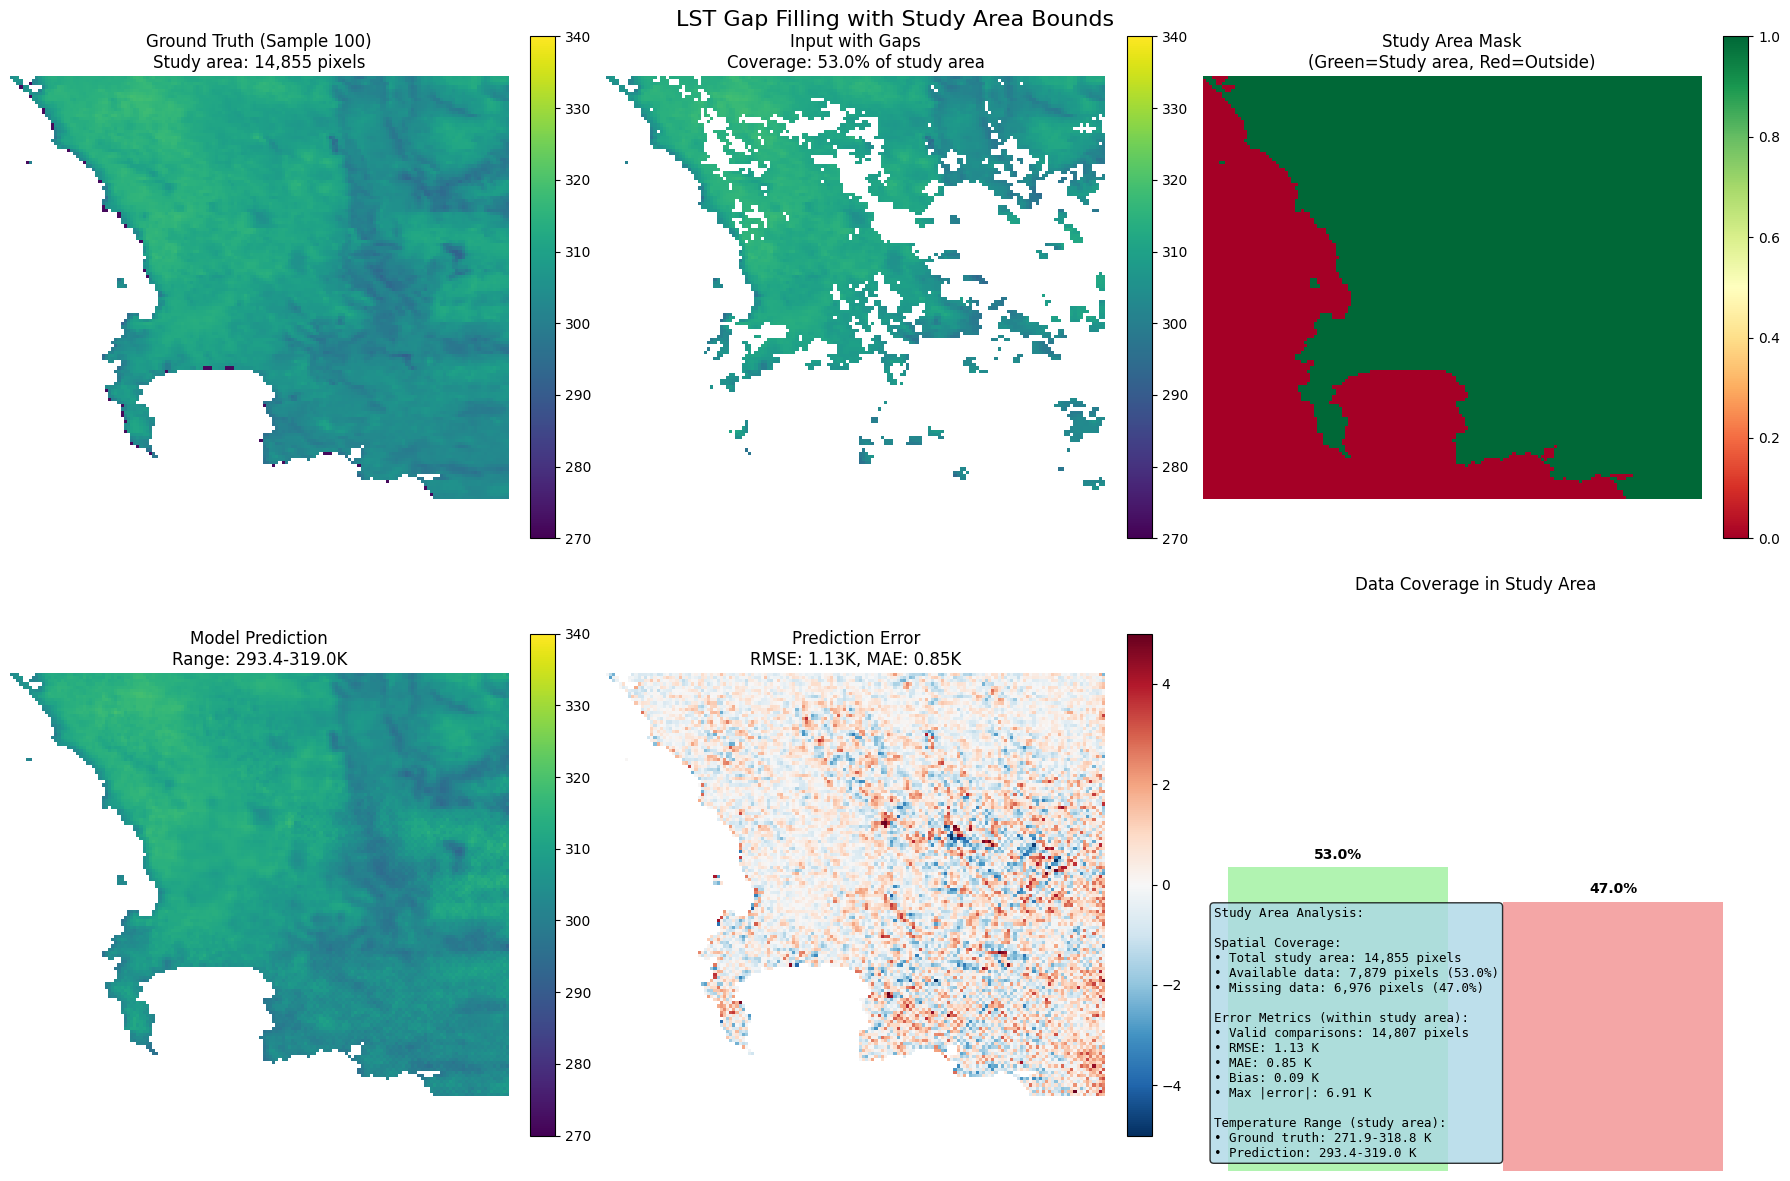


SAMPLE 100 - STUDY AREA ANALYSIS
Study area definition:
  Total image size: (134, 158)
  Study area: 14,855 pixels (70.2% of image)
  Outside study area: 6,317 pixels

Data availability within study area:
  Available: 7,879 pixels (53.0%)
  Missing: 6,976 pixels (47.0%)
  Gap filling needed for: 6,976 pixels

Temperature analysis (study area only):
  Ground truth range: 271.9 - 318.8 K
  Prediction range: 293.4 - 319.0 K
  Temperature span: 46.9 K

Error analysis (14,807 comparable pixels):
  RMSE: 1.13 K (2.4% of temp range)
  MAE: 0.85 K
  Bias: 0.09 K (warm bias)
  Error range: -6.33 to 6.91 K


In [77]:
visualize_sample_prediction_with_ground_mask(
    model=model, 
    train_dataset=train_dataset, 
    ground_msk=ground_msk,  # Your external mask array
    device='cuda', 
    sample_idx=100
)

_________________________

### Evaluating on Test Set:

In [ ]:
def evaluate_on_test_set(model, test_loader, test_dataset, device='cuda'):
    """
    Evaluate trained model on test set
    """
    print("\n" + "="*60)
    print("EVALUATING ON TEST SET")
    print("="*60)
    
    model.eval()
    predictions = []
    original_inputs = []
    masks = []
    
    print(f"Running inference on {len(test_loader)} test batches...")
    
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            inputs = batch['input'].to(device)
            input_masks = batch['mask'].to(device)
            
            # Store original inputs (normalized) for later denormalization
            original_inputs.extend(inputs.cpu().numpy())
            masks.extend(input_masks.cpu().numpy())
            
            # Run model
            outputs = model(inputs, input_masks)
            
            # Denormalize predictions back to Kelvin
            outputs_denorm = test_dataset.denormalize(outputs)
            predictions.extend(outputs_denorm.cpu().numpy())
    
    # Convert to numpy arrays
    predictions = np.array(predictions)
    original_inputs = np.array(original_inputs)
    masks = np.array(masks)
    
    # Denormalize original inputs for comparison
    original_inputs_torch = torch.FloatTensor(original_inputs)
    original_inputs_denorm = test_dataset.denormalize(original_inputs_torch).numpy()
    
    print(f"✓ Generated {len(predictions)} predictions")
    
    return predictions, original_inputs_denorm, masks

def calculate_test_metrics(predictions, original_inputs, masks):
    """
    Calculate evaluation metrics on test set
    """
    print("\nCalculating test metrics...")
    
    all_original_valid = []
    all_predictions_valid = []
    per_image_metrics = {'rmse': [], 'mae': [], 'bias': [], 'r2': []}
    
    for i in range(len(predictions)):
        pred = predictions[i, 0]  # Remove channel dimension
        orig = original_inputs[i, 0]  # Remove channel dimension  
        mask = masks[i, 0]  # Remove channel dimension
        
        # Find pixels that were originally valid (not missing)
        valid_pixels = mask > 0
        
        if valid_pixels.sum() == 0:
            continue  # Skip images with no valid pixels
        
        # Extract valid pixels for comparison
        orig_valid = orig[valid_pixels]
        pred_valid = pred[valid_pixels]
        
        # Store for overall metrics
        all_original_valid.extend(orig_valid)
        all_predictions_valid.extend(pred_valid)
        
        # Calculate per-image metrics
        rmse = np.sqrt(np.mean((pred_valid - orig_valid)**2))
        mae = np.mean(np.abs(pred_valid - orig_valid))
        bias = np.mean(pred_valid - orig_valid)
        
        # R² score
        if len(orig_valid) > 1 and np.var(orig_valid) > 0:
            r2 = 1 - np.sum((orig_valid - pred_valid)**2) / np.sum((orig_valid - np.mean(orig_valid))**2)
        else:
            r2 = 0
        
        per_image_metrics['rmse'].append(rmse)
        per_image_metrics['mae'].append(mae)
        per_image_metrics['bias'].append(bias)
        per_image_metrics['r2'].append(r2)
    
    # Calculate overall metrics
    all_original_valid = np.array(all_original_valid)
    all_predictions_valid = np.array(all_predictions_valid)
    
    overall_rmse = np.sqrt(np.mean((all_predictions_valid - all_original_valid)**2))
    overall_mae = np.mean(np.abs(all_predictions_valid - all_original_valid))
    overall_bias = np.mean(all_predictions_valid - all_original_valid)
    overall_r2 = 1 - np.sum((all_original_valid - all_predictions_valid)**2) / np.sum((all_original_valid - np.mean(all_original_valid))**2)
    
    # Print results
    print(f"\nTEST SET EVALUATION RESULTS:")
    print(f"="*50)
    print(f"Overall Metrics (across all {len(all_original_valid):,} pixels):")
    print(f"  RMSE: {overall_rmse:.3f} K")
    print(f"  MAE:  {overall_mae:.3f} K")
    print(f"  Bias: {overall_bias:.3f} K")
    print(f"  R²:   {overall_r2:.4f}")
    
    print(f"\nPer-Image Statistics (across {len(per_image_metrics['rmse'])} images):")
    for metric in ['rmse', 'mae', 'bias', 'r2']:
        values = per_image_metrics[metric]
        print(f"  {metric.upper()}: {np.mean(values):.3f} ± {np.std(values):.3f} (mean ± std)")
    
    return {
        'overall_rmse': overall_rmse,
        'overall_mae': overall_mae,
        'overall_bias': overall_bias,
        'overall_r2': overall_r2,
        'per_image_metrics': per_image_metrics
    }


In [34]:
def visualize_test_results(predictions, original_inputs, masks, num_examples=6):
    """
    Visualize some test results
    """
    print(f"\nVisualizing {num_examples} test examples...")
    
    # Select random examples
    np.random.seed(42)
    indices = np.random.choice(len(predictions), min(num_examples, len(predictions)), replace=False)
    
    fig, axes = plt.subplots(3, num_examples, figsize=(4*num_examples, 12))
    
    # Store images for shared colorbars
    temp_images = []
    diff_images = []
    
    for idx, img_idx in enumerate(indices):
        pred = predictions[img_idx, 0]
        orig = original_inputs[img_idx, 0]
        mask = masks[img_idx, 0]
        
        # Create masked version for visualization
        orig_masked = orig.copy()
        orig_masked[mask == 0] = np.nan
        
        # Coverage
        coverage = mask.mean() * 100
        
        # Temperature range
        vmin = min(np.nanmin(orig), pred.min())
        vmax = max(np.nanmax(orig), pred.max())
        
        col = idx if num_examples > 1 else 0
        
        # Original with gaps
        im1 = axes[0, col].imshow(orig_masked, cmap='viridis', vmin=vmin, vmax=vmax, origin='lower')
        axes[0, col].set_title(f'Original (Test {img_idx})\nCoverage: {coverage:.1f}%')
        axes[0, col].axis('off')
        temp_images.append(im1)
        
        # Gap-filled prediction
        pred_masked = np.ma.masked_where(~ground_msk, pred)
        im2 = axes[1, col].imshow(pred_masked, cmap='viridis', vmin=vmin, vmax=vmax, origin='lower')
        axes[1, col].set_title(f'Gap-filled Prediction')
        axes[1, col].axis('off')
        
        # Difference (only where original data exists)
        diff = pred - orig
        diff_masked = np.where(mask > 0, diff, np.nan)
        im3 = axes[2, col].imshow(diff_masked, cmap='RdBu_r', vmin=-5, vmax=5, origin='lower')
        axes[2, col].set_title(f'Difference\n(Pred - Original)')
        axes[2, col].axis('off')
        diff_images.append(im3)
    
    # Add shared colorbars for each row
    fig.colorbar(temp_images[0], ax=axes[0, :], shrink=0.8, aspect=30)
    fig.colorbar(temp_images[0], ax=axes[1, :], shrink=0.8, aspect=30)
    fig.colorbar(diff_images[0], ax=axes[2, :], shrink=0.8, aspect=30)
    
    # plt.tight_layout()
    plt.show()

In [ ]:
model = PartialUNet(in_channels=1, out_channels=1)
model.load_state_dict(torch.load('best_partial_unet.pth', map_location=device))
model.to(device)
model.eval()  # Setting to evaluation mode

print("✓ Loaded trained model from 'best_partial_unet.pth'")

✓ Loaded trained model from 'best_partial_unet.pth'



RUNNING COMPLETE WORKFLOW

EVALUATING ON TEST SET
Running inference on 29 test batches...


✓ Generated 172 predictions

Calculating test metrics...

TEST SET EVALUATION RESULTS:
Overall Metrics (across all 1,914,534 pixels):
  RMSE: 0.902 K
  MAE:  0.623 K
  Bias: -0.002 K
  R²:   0.9901

Per-Image Statistics (across 172 images):
  RMSE: 0.892 ± 0.226 (mean ± std)
  MAE: 0.637 ± 0.170 (mean ± std)
  BIAS: -0.002 ± 0.053 (mean ± std)
  R2: 0.935 ± 0.040 (mean ± std)

Visualizing 6 test examples...


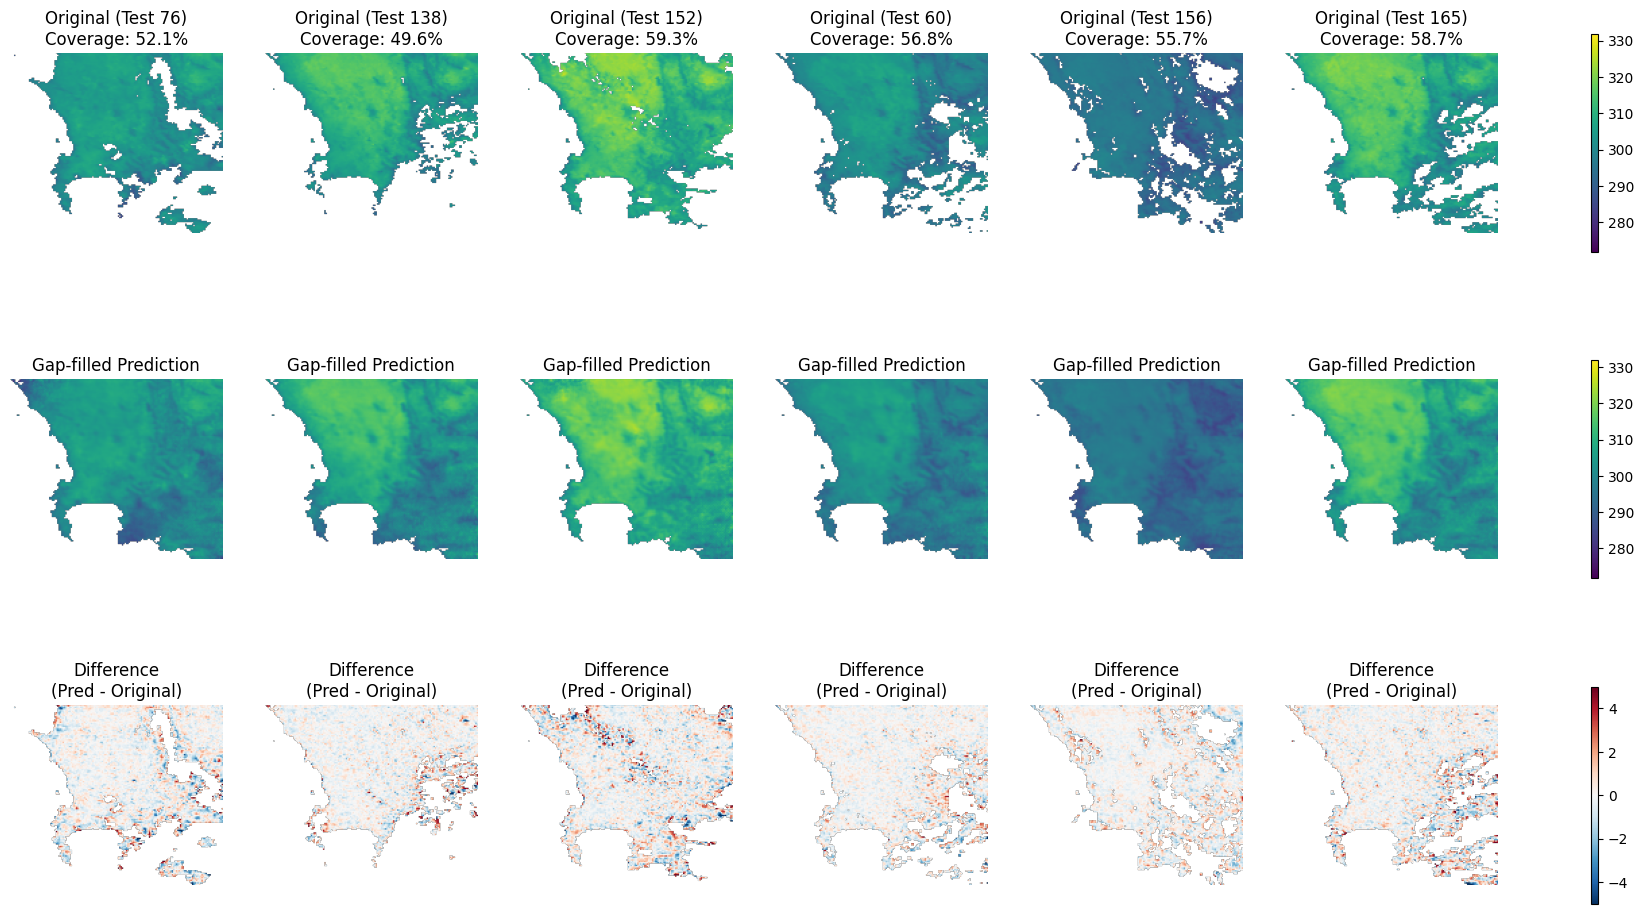


Saving test predictions...
✓ Test predictions saved to 'test_predictions.npy'

🎉 EVALUATION COMPLETE!
Final Test Results:
  RMSE: 0.90 K
  MAE:  0.62 K
  R²:   0.9901


In [ ]:
print("\n" + "="*80)
print("RUNNING COMPLETE WORKFLOW")
print("="*80)

# After training is complete, evaluate on test set
predictions, original_inputs_denorm, test_masks = evaluate_on_test_set(
    model, test_loader, test_dataset, device
)

# Calculate metrics
test_results = calculate_test_metrics(predictions, original_inputs_denorm, test_masks)

# Visualize results
visualize_test_results(predictions, original_inputs_denorm, test_masks, num_examples=6)

# Saving results
print(f"\nSaving test predictions...")
np.save('./test_predictions.npy', predictions)
print(f"✓ Test predictions saved to 'test_predictions.npy'")

print(f"\n🎉 EVALUATION COMPLETE!")
print(f"Final Test Results:")
print(f"  RMSE: {test_results['overall_rmse']:.2f} K")
print(f"  MAE:  {test_results['overall_mae']:.2f} K")
print(f"  R²:   {test_results['overall_r2']:.4f}")

____